## Overview

The goal of this project is to analyze yelp reviews with the goal to understand the positive, negative, and neutral ratio of reviews using polarity and subjectivity as metrics. The main goal here is to identify how many of these reviews are positive/negative vs neutral using VADER and TextBlob as parameters.

Key questions of the analysis:

* What is the distribution of good reviews vs bad reviews vs neutral reviews using VADER and TextBlob.
* What are the polarity and subjectivity scores of all the reviews.
* Compared to the initial benchmark model, what's difference in scores between models?

___

## Data Analysis

In [1]:
# imports
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from functions import clean_data, clean_text, show_wordcloud, get_top_n_words, dist_chart, count_punct, pie_chart

import nltk
from nltk import pos_tag
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
#nltk.download('vader_lexicon')
from textblob import TextBlob
from wordcloud import WordCloud

%matplotlib inline

In [2]:
# read csv
df = pd.read_csv('/Users/gonzandrobles/Desktop/Python/ipynb_notebooks/other_projects/nlp_projects/capstone_project/reviews.csv')
df = clean_data(df)

In [3]:
# dataset shape
df.shape

(221, 5)

In [4]:
# check the first 5 observations
df.head()

,username,location,date,rating,content
0,Abdul Rafay K.,"Chapel Hill, NC",2019-12-15,5.0,I spent about two hours here in order to focus...
1,Jennifer L.,"Seattle, WA",2019-01-27,4.0,I love the vibe here! It gets pretty busy espe...
2,Stacy A.,"Federal Way, WA",2019-11-05,3.0,Probably I came here on the wrong day because ...
3,Yoni C.,"Issaquah, WA",2019-11-03,5.0,It was after visiting Tacoma Art Museum and ni...
4,Keri F.,"Seattle, WA",2019-08-18,5.0,Wonderful cafe and roasterie in Tacoma. Came h...


In [5]:
# the date is an object so we need to convert it to datetime
df['date'] = pd.to_datetime(df['date'])

In [6]:
# checking for the data types of df
df.dtypes

username            object
location            object
date        datetime64[ns]
rating             float64
content             object
dtype: object

In [7]:
# how many unique elements
df.nunique()

username    218
location     82
date        214
rating        5
content     221
dtype: int64

In [8]:
# any duplicates?
df.duplicated().sum()

0

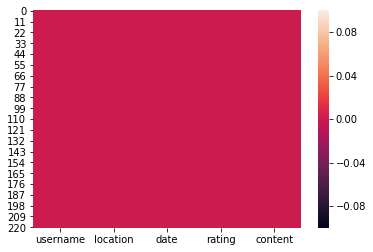

In [9]:
# null values?
sns.heatmap(df.isnull());

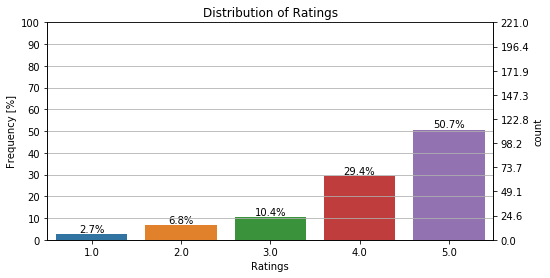

In [10]:
dist_chart(df)

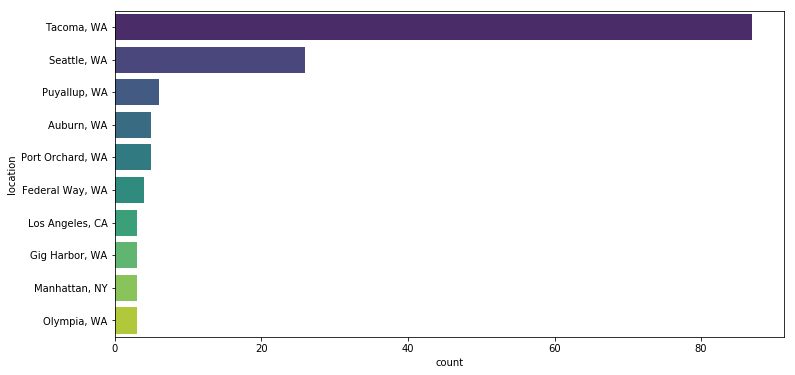

In [11]:
# Top 10 cities where reviews come from
plt.figure(figsize=(12, 6))
time_count = sns.countplot(y=df['location'], palette='viridis', order=df['location'].value_counts()[:10].index)
time_count;

In [12]:
df["location"].value_counts(normalize = True)[:10]

Tacoma, WA          0.393665
Seattle, WA         0.117647
Puyallup, WA        0.027149
Auburn, WA          0.022624
Port Orchard, WA    0.022624
Federal Way, WA     0.018100
Los Angeles, CA     0.013575
Gig Harbor, WA      0.013575
Manhattan, NY       0.013575
Olympia, WA         0.013575
Name: location, dtype: float64

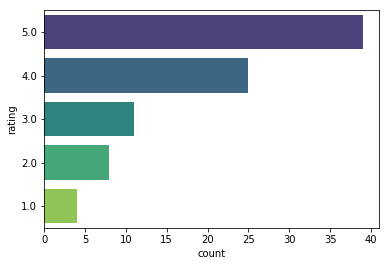

In [13]:
# counts of reviews in Tacoma
tacoma_rating = df.query('location == "Tacoma, WA"')['rating']
sns.countplot(y=tacoma_rating, palette='viridis', order=tacoma_rating.value_counts().index);

Since the coffee shop is located in Tacoma, it makes a lot of sense that most of the reviews come from the same location and most of those reviews are either 4 or 5 stars.

___

## Feature Extraction

In [14]:
# create two new columns for year and month to check reviews per year and month
df_copy = df.copy()
df_copy['reviews_per_year'] = df['date'].dt.year
df_copy['reviews_per_month'] = df['date'].dt.month

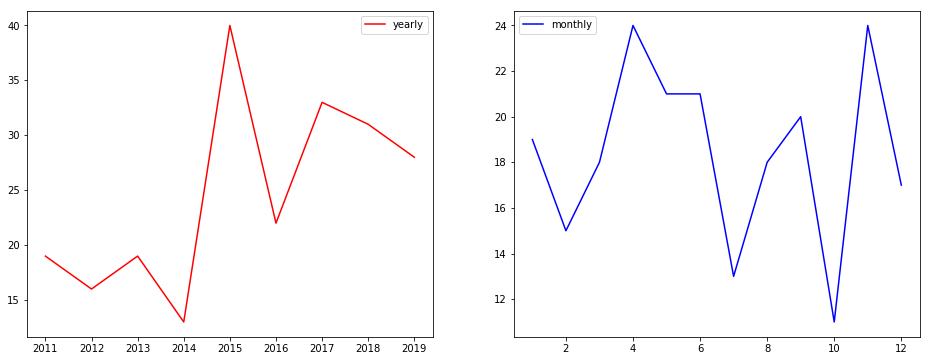

In [15]:
# linear plot for yearly and monthly reviews
fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.lineplot(data=df_copy['reviews_per_year'].value_counts(), color="red", label="yearly", ax=ax[0])
sns.lineplot(data=df_copy['reviews_per_month'].value_counts(), color="blue", label="monthly", ax=ax[1]);

In [16]:
per_year = df_copy['reviews_per_year'].value_counts().max()
per_month = df_copy['reviews_per_month'].value_counts().max()
print(f'''2015 was the year with most reviews: {per_year}, 
while April and November are the months with more reviews: {per_month}''')

2015 was the year with most reviews: 40, 
while April and November are the months with more reviews: 24


In [17]:
df_copy['body_len'] = df['content'].apply(lambda x: len(x) - x.count(" "))
df_copy['punct%'] = df['content'].apply(lambda x: count_punct(x))

In [18]:
df_copy.head()

,username,location,date,rating,content,reviews_per_year,reviews_per_month,body_len,punct%
0,Abdul Rafay K.,"Chapel Hill, NC",2019-12-15,5.0,I spent about two hours here in order to focus...,2019,12,225,2.7
1,Jennifer L.,"Seattle, WA",2019-01-27,4.0,I love the vibe here! It gets pretty busy espe...,2019,1,530,2.8
2,Stacy A.,"Federal Way, WA",2019-11-05,3.0,Probably I came here on the wrong day because ...,2019,11,293,2.0
3,Yoni C.,"Issaquah, WA",2019-11-03,5.0,It was after visiting Tacoma Art Museum and ni...,2019,11,219,1.8
4,Keri F.,"Seattle, WA",2019-08-18,5.0,Wonderful cafe and roasterie in Tacoma. Came h...,2019,8,211,4.3


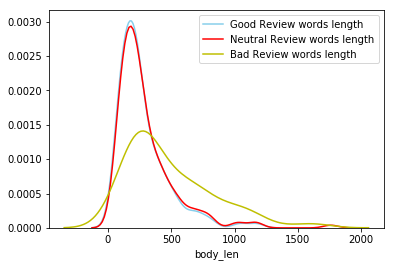

In [19]:
# distribution of number of words by rating ( 5 stars, 4 stars, less than 4)
good_rating = df_copy.query('rating == 5')['body_len']
neutral_rating = df_copy.query('rating >= 4')['body_len']
bad_rating = df_copy.query('rating < 4')['body_len']

sns.distplot(good_rating , color="skyblue", label="Good Review words length", hist=False)
sns.distplot(neutral_rating , color="red", label="Neutral Review words length", hist=False)
sns.distplot(bad_rating , color="y", label="Bad Review words length", hist=False);

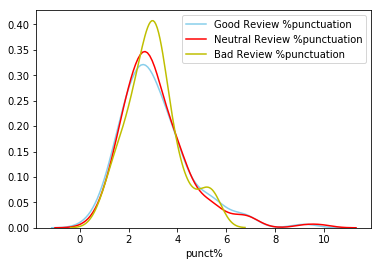

In [20]:
# distribution of number of words by rating ( 5 stars, 4 stars, less than 4)
good_rating = df_copy.query('rating == 5')['punct%']
neutral_rating = df_copy.query('rating >= 4')['punct%']
bad_rating = df_copy.query('rating < 4')['punct%']

sns.distplot(good_rating , color="skyblue", label="Good Review %punctuation", hist=False)
sns.distplot(neutral_rating , color="red", label="Neutral Review %punctuation", hist=False)
sns.distplot(bad_rating , color="y", label="Bad Review %punctuation", hist=False);

We can see that bad reviews tend to have more words than good or neutral reviews. I guess that's normal since bad reviews are usually more detailed than good reviews.

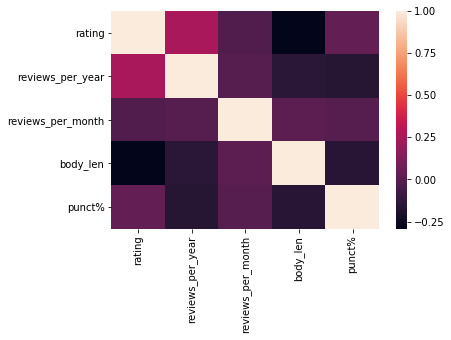

In [21]:
# checking for correlation between variables
sns.heatmap(df_copy.corr());

We can't see any clear correlations of what customers have when writting reviews.

___

## Benchmarking Model

Just to set up a benchmark we are going to assume that all 5 stars reviews are good reviews, all 4 stars reviews are neutral and everything below 4 is a bad review. The distribution for this reviews without VADER

In [22]:
good = df.query('rating == 5')
neutral = df.query('rating == 4')
bad = df.query('rating < 4')

print(f'good reviews: {round(good.shape[0]/df.shape[0]*100)} \
| bad reviews: {round(bad.shape[0]/df.shape[0]*100)} \
| neutral reviews: {round(neutral.shape[0]/df.shape[0]*100)}\n')

print(f'good reviews count: {good.shape[0]} \
| bad reviews count: {bad.shape[0]} \
| neutral reviews count: {neutral.shape[0]}')

good reviews: 51 | bad reviews: 20 | neutral reviews: 29

good reviews count: 112 | bad reviews count: 44 | neutral reviews count: 65


51% of the reviews are good, 20% of the reviews are bad reviews and 29% of the reviews are neutral, this scores does not include subjectivity and polarity, in the next model we are going to include these metrics to compare them with the benchmark model. 

Let's also create an analysis without cleaning the words.

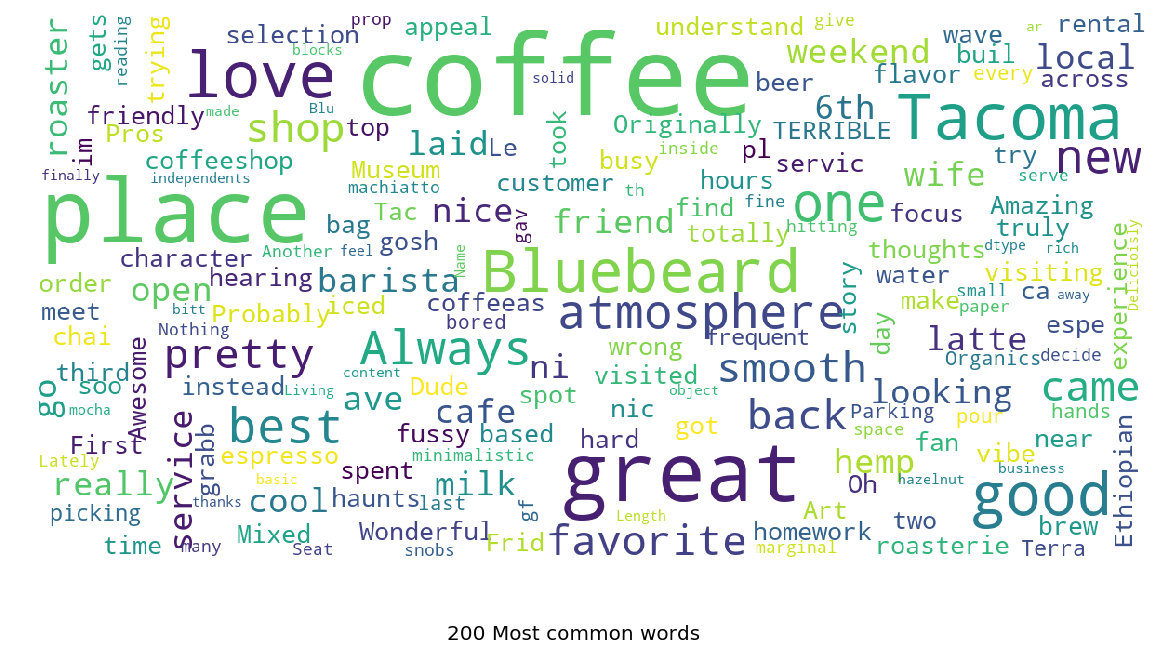

In [23]:
show_wordcloud(df["content"], '200 Most common words')

In [24]:
# add sentiment anaylsis columns
sia = SentimentIntensityAnalyzer()
df["sentiments"] = df["content"].apply(lambda x: sia.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

In [25]:
# add number of characters column
df["nb_chars"] = df["content"].apply(lambda x: len(x))

# add number of words column
df["nb_words"] = df["content"].apply(lambda x: len(x.split(" ")))

In [26]:
df.head()

,username,location,date,rating,content,neg,neu,pos,compound,nb_chars,nb_words
0,Abdul Rafay K.,"Chapel Hill, NC",2019-12-15,5.0,I spent about two hours here in order to focus...,0.000,0.792,0.208,0.8830,274,50
1,Jennifer L.,"Seattle, WA",2019-01-27,4.0,I love the vibe here! It gets pretty busy espe...,0.068,0.800,0.132,0.7562,648,119
2,Stacy A.,"Federal Way, WA",2019-11-05,3.0,Probably I came here on the wrong day because ...,0.112,0.703,0.185,0.7697,359,67
3,Yoni C.,"Issaquah, WA",2019-11-03,5.0,It was after visiting Tacoma Art Museum and ni...,0.033,0.547,0.421,0.9783,266,48
4,Keri F.,"Seattle, WA",2019-08-18,5.0,Wonderful cafe and roasterie in Tacoma. Came h...,0.000,0.616,0.384,0.9715,251,41


In [27]:
# highest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("pos", ascending = False)[["content", "pos"]].head(10)

,content,pos
49,Nice People awesome 3rd wave coffee friendly l...,0.675
144,Best coffee in town. Lots of seating great wi-...,0.564
152,My latte was delicious and I loved the space. ...,0.561
157,Great space. Good coffee. Friendly and faster ...,0.551
112,Coffee wise theyre good not as good as valhall...,0.519
168,Best best best in Tacoma! Atmosphere coffee st...,0.496
166,Super cute coffee place coffee was great! Awe...,0.494
161,Love this place. Great vibe and coffee. Also p...,0.478
110,Great coffee chill atmosphere and friendly sta...,0.467
145,The coffee here is amazing. The baristas are a...,0.460


In [28]:
# lowest negative sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("neg", ascending = False)[["content", "neg"]].head(10)

,content,neg
214,Had a basic mocha very good and smooth no bitt...,0.258
169,Since i go to Caffe Dei and have orange chocol...,0.250
77,The atmosphere is not as nice as other coffee ...,0.197
88,This place is awesome. My tinder date slowly w...,0.187
163,I've heard nothing but good things about this ...,0.174
194,The iced chai was good. I'm pretty fussy about...,0.173
153,Two shots with foam was yummi no foam art :( B...,0.162
106,Cute little hipster type coffee shop. Really n...,0.154
22,Good coffee. TERRIBLE customer service. Can im...,0.150
181,One star only due to location. Rude baristas w...,0.144


In [29]:
df[df["nb_words"] >= 5].sort_values("neu", ascending = False)[["content", "pos"]].head(10)

,content,pos
92,Went here today and had the nitro cold brew. I...,0.000
172,Were you a fan of Blackwater Coffee? Former ow...,0.067
150,The atmosphere is nice but the wifi speed need...,0.073
199,last weekend me and my gf were bored so we gav...,0.064
39,I'm a coffee snob. In my hometown there are ju...,0.078
126,A good cup of joe that doesn't assert itself a...,0.082
105,I used to get the ground blend online from my ...,0.088
136,Small menu but I see that alot of people come ...,0.111
8,Mixed thoughts. Originally came here based on ...,0.084
159,Don't expect any frills--simple drinks concret...,0.070


In [30]:
# Sentiments by Review
print('{:40} : {:10} : {:10}'.format("Review", "Polarity", "Subjectivity") )

for review in df['content']:
    #Find sentiment of a review
    sentiment = TextBlob(review)
    #Print individual sentiments
    print('{:40} :   {: 01.2f}    :   {:01.2f}'.format(review[:40]\
                , sentiment.polarity, sentiment.subjectivity) )

Review                                   : Polarity   : Subjectivity
I spent about two hours here in order to :    0.28    :   0.55
I love the vibe here! It gets pretty bus :    0.23    :   0.50
Probably I came here on the wrong day be :    0.17    :   0.57
It was after visiting Tacoma Art Museum  :    0.41    :   0.65
Wonderful cafe and roasterie in Tacoma.  :    0.70    :   0.72
This is a great third wave coffeeshop an :    0.33    :   0.61
Great service and atmosphere. The select :    0.57    :   0.65
Awesome coffee and the Baristas are real :    0.59    :   0.90
Mixed thoughts. Originally came here bas :    0.02    :   0.41
Being new to Tacoma I have been looking  :    0.23    :   0.51
Just not a fan of the flavor or the coff :    0.29    :   0.42
Oh my gosh This was a great experience!  :    0.40    :   0.70
This is one of my top 2 favorite places  :    0.05    :   0.56
Always up for trying new local coffee. I :    0.26    :   0.58
Great coffeeas a barista across the wate :    0.1

Really great coffee with terrible hipste :   -0.16    :   0.91
Super cute coffee place coffee was great :    0.39    :   0.64
Coffee would be four stars service a one :    0.30    :   0.68
Best best best in Tacoma! Atmosphere cof :    0.84    :   0.42
Since i go to Caffe Dei and have orange  :   -0.21    :   0.54
Coffee is really good prices are cheap a :    0.40    :   0.53
The coffee: exquisitely bright and burst :    0.21    :   0.40
Were you a fan of Blackwater Coffee? For :    0.00    :   0.00
When I go to a coffee shop I am looking  :    0.21    :   0.55
At time of this post they have the best  :    0.42    :   0.41
One is Tacoma'a best roasters and coffee :    0.35    :   0.54
My favorite coffee shop in tacoma. Excel :    0.53    :   0.75
I went here with my partner. He ordered  :    0.10    :   0.56
As a student I am always looking for new :    0.15    :   0.45
I get Bluebeard coffee almost every week :    1.00    :   0.30
I checked out this cute new spot this mo :    0.27    :

Final summarized counts : [57, 131, 33]

 Pie Representation 
-------------------


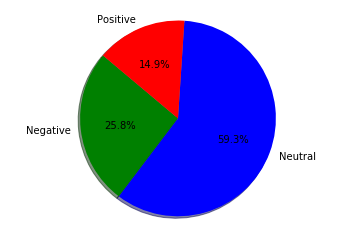

In [31]:
pie_chart(df,'content')

In [32]:
# Most common words
common_words = get_top_n_words(df['content'], 20)
for word, freq in common_words:
    print(word, freq)

the 754
and 589
to 391
coffee 332
it 280
is 265
of 262
was 236
in 225
for 186
my 174
with 163
they 148
that 143
this 136
but 126
place 118
here 114
great 113
on 110


___

## Clean Data

In order the get an appropiate sentiment analysis we need to clean the dataset by removing stopwords, punctuations, lemmatize the corpus, bring everthing to lower case. Then with this new parameters we are going to compare the bench mark model with this new clean model and check if there are any differences between each other.

In [33]:
# clean text data
df["clean_content"] = df["content"].apply(lambda x: clean_text(x))

Let's drop unnecessary columns for the model

In [34]:
df.drop(columns=['username', 'location', 'date', 'content', 'neg', 'pos', 'neu','compound', 'nb_chars','nb_words'],\
        inplace=True)

___

## Sentiment Analysis

In [35]:
# add sentiment anaylsis columns
sia = SentimentIntensityAnalyzer()
df["sentiments"] = df["clean_content"].apply(lambda x: sia.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

In [36]:
# add number of characters column
df["nb_chars"] = df["clean_content"].apply(lambda x: len(x))

# add number of words column
df["nb_words"] = df["clean_content"].apply(lambda x: len(x.split(" ")))

In [37]:
df.head()

,rating,clean_content,neg,neu,pos,compound,nb_chars,nb_words
0,5.0,spend two hour order focus work order latte so...,0.000,0.661,0.339,0.8832,168,26
1,4.0,love vibe get pretty busy especially student r...,0.034,0.701,0.265,0.9472,393,61
2,3.0,probably come wrong day go homework wifi work ...,0.223,0.485,0.293,0.6361,187,30
3,5.0,visit tacoma art museum nice stop really like ...,0.051,0.346,0.603,0.9716,163,25
4,5.0,wonderful cafe roasterie tacoma come study caf...,0.000,0.455,0.545,0.9705,173,24


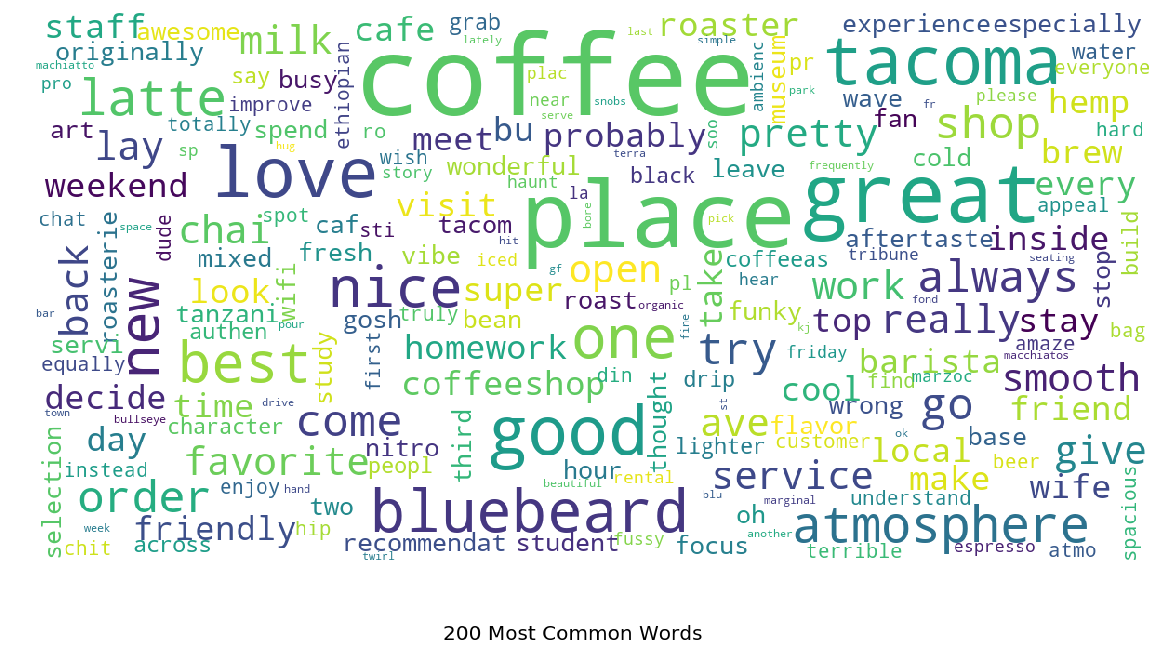

In [38]:
show_wordcloud(df["clean_content"],'200 Most Common Words')

In [39]:
# highest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("pos", ascending = False)[["clean_content", "pos"]].head(10)

,clean_content,pos
152,latte delicious love space barista really swee...,0.782
49,nice people awesome wave coffee friendly location,0.716
168,best best best tacoma atmosphere coffee staff ...,0.714
145,coffee amaze baristas super nice location perf...,0.658
16,great place great character build great staff ...,0.640
103,husband stop see high review wonderful love at...,0.632
157,great space good coffee friendly fast staff ma...,0.632
144,best coffee town lot seat great wi-fi nice loc...,0.628
23,dude best coffee ever truly make love wish sti...,0.609
3,visit tacoma art museum nice stop really like ...,0.603


In [40]:
# lowest negative sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("neg", ascending = False)[["clean_content", "neg"]].head(10)

,clean_content,neg
214,basic mocha good smooth bitterness could bite ...,0.353
165,really great coffee terrible hipster service q...,0.331
88,place awesome tinder date slowly go shit hell ...,0.252
210,go back nothing like proper latte middle day,0.232
81,i'm vegan totally space ask sub milk mind pay ...,0.224
2,probably come wrong day go homework wifi work ...,0.223
169,since go caffe dei orange chocolate coffee dri...,0.221
40,place suck offer quality coffee reasonable pri...,0.213
203,wife coffee snobs bluebeard one best best town...,0.211
155,yummy coffee nice open space great person need...,0.201


In [41]:
df[df["nb_words"] >= 5].sort_values("neu", ascending = False)[["clean_content", "pos"]].head(10)

,clean_content,pos
215,delicioisly smooth hazelnut latte....thanks mi...,0.000
92,go today nitro cold brew point can't wait,0.000
136,small menu see alot people come study hang ope...,0.156
150,atmosphere nice wifi speed need lot fast accom...,0.157
159,expect frills--simple drink concrete floor wei...,0.084
126,good cup joe assert ahead pack way street jam ...,0.128
105,use get ground blend online weekly delivery te...,0.154
176,favorite coffee shop tacoma excellent staff ro...,0.211
87,fall winter summer spring...trendy hipster env...,0.195
162,roast coffee average receive customer service ...,0.100


Final summarized counts : [51, 131, 39]

 Pie Representation 
-------------------


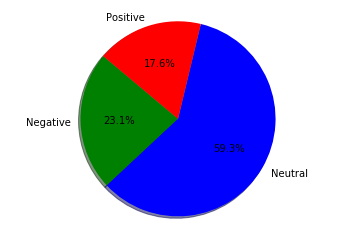

In [42]:
pie_chart(df, 'clean_content')

In [43]:
# Sentiments by Review
print('{:40} : {:10} : {:10}'.format("Review", "Polarity", "Subjectivity") )

for review in df['clean_content']:
    #Find sentiment of a review
    sentiment = TextBlob(review)
    #Print individual sentiments
    print('{:40} :   {: 01.2f}    :   {:01.2f}'.format(review[:40]\
                , sentiment.polarity, sentiment.subjectivity) )

Review                                   : Polarity   : Subjectivity
spend two hour order focus work order la :    0.38    :   0.77
love vibe get pretty busy especially stu :    0.19    :   0.50
probably come wrong day go homework wifi :    0.06    :   0.63
visit tacoma art museum nice stop really :    0.34    :   0.55
wonderful cafe roasterie tacoma come stu :    0.79    :   0.80
great third wave coffeeshop probably one :    0.38    :   0.62
great service atmosphere selection roast :    0.46    :   0.56
awesome coffee baristas really nice stay :    0.59    :   0.90
mixed thought originally come base recom :   -0.01    :   0.45
new tacoma look good coffee shop order t :    0.25    :   0.48
fan flavor coffee leave funky aftertaste :    0.43    :   0.63
oh gosh great experience try order nitro :    0.37    :   0.70
one top favorite place go tacoma fresh l :    0.20    :   0.57
always try new local coffee grab black d :    0.26    :   0.58
great coffeeas barista across water say  :    0.2

i've heard nothing good thing place admi :    0.13    :   0.49
well coffee good atmosphere i'm fan blen :    0.31    :   0.66
really great coffee terrible hipster ser :   -0.16    :   0.91
super cute coffee place coffee great awe :    0.37    :   0.64
coffee would four star service one simpl :    0.30    :   0.68
best best best tacoma atmosphere coffee  :    0.78    :   0.45
since go caffe dei orange chocolate coff :    0.08    :   0.48
coffee really good price cheap wifi free :    0.38    :   0.53
coffee exquisitely bright burst floral n :    0.21    :   0.40
fan blackwater coffee former owner/baris :    0.00    :   0.00
go coffee shop look thing particular wan :    0.31    :   0.58
time post best espresso tacoma imo hang  :    0.42    :   0.41
one tacoma'a best roaster coffee shop ke :    0.40    :   0.55
favorite coffee shop tacoma excellent st :    0.38    :   0.62
go partner order drip order nonfat sugar :    0.15    :   0.55
student always look new study spot one t :    0.16    :

In [44]:
# Most common words
common_words = get_top_n_words(df['clean_content'], 20)
for word, freq in common_words:
    print(word, freq)

coffee 338
place 141
great 113
good 106
like 90
get 81
bluebeard 71
one 71
go 70
shop 70
tacoma 69
make 64
latte 63
friendly 57
really 55
come 53
nice 52
love 50
drink 48
work 47


___

## Conclusions:

We applied the same process to two models with different parameters, this are the results:

**Benchmark Model:**

* We started by simply separating the data in 3 categories - good, bad and neutral just by the number of stars the review has, assuming 5 stars was good, 4 stars was neutral and below 4 was bad. We don't have any parameters here, just intuition.

    * Right here the distribution was: `good reviews 112 -> (51%)` | `bad reviews 44 -> (20%)` | `neutral reviews 65 -> (29%)`
    
    
* After that we plot a wordcloud with the most frequent words but we can see some random words like: `prop, buil, th, nic, im, ni, gav, pl` among others that doesn't really mean anything.


* Then we used `TextBlob` to calculate *polarity* and *subjectivity* of the corpus, we obtained the following results:
    * The counts for bad reviews was `57 -> (25.8%)`, neutral reviews `131 -> (59.3%)` and good reviews `33 -> (14.9%)`
    
    
* Finally we obtained the 20 most frequent words of the model:

`the 754 | and 589 | to 391 | coffee 332 | it 280 | is 265 | of 262 | was 236 | in 225 | for 186 | my 174 | with 163 | they 148 | that 143 | this 136 | but 126 | place 118 | here 114 | great 113 | on 110`
    
Even when we didn't clean the corpus we can see that `TextBlob` gave us different numbers than the ones we assumed in the beginning, the difference in positive rating is `55` or `36.1%`, the neutral rating differs by `66` or `30.30%` and the bad rating has a difference of `13` or `5.8%`. The top 20 most frequent words are basically useless since all of this are mostly stop words which are neutral words and doesn't represent the any sentiment.



**Tuned Model**

* We tuned the parameters by cleaning the content and turning all the text lowercase, eliminating punctuation marks and stopwords, tokenizing the text, and separating the words from numbers; once we finished this process we apply the same functions to the corpus that we applied to the benchmark model to see the differences.


* We can start seeing some differences in the wordcloud by having words that makes more sense that the ones with the "dirty content" but we still have some random words like `gf, la, fr`. Even with these random words the cloud looks cleaner and gives us better idea of what the customers think of the coffee shop.


* The TextBlob results we got back after cleaning the content were:
    * The counts for bad reviews was `51 -> (23.1%)`, neutral reviews `131 -> (59.3%)` and good reviews `39 -> (17.6%)`. Compared with the previous model we have a tradeoff of `2.70%` from bad reviews to good reviews, neutral reviews stayed the same.
    

* The 20 most frequent words of this model are:

`coffee 338 | place 141 | great 113 | good 106 | like 90 | get 81 | bluebeard 71 | one 71 | go 70 | shop 70 | tacoma 69 | make 64  |latte 63 | friendly 57 | really 55 | come 53 | nice 52 | love 50 | drink 48 | work 47`

As we can see these list of words make more sense than the previous ones and we get a better idea of what this place looks like. We can conclude that the second model performs better, eventhough the difference between models was only 2.70%, we can get a better idea of what this place represent in the mind of the customers by eliminating neutral words. The neutral reviews are the majority in both models, these neutral reviews represent the most objective reviews in the dataset.